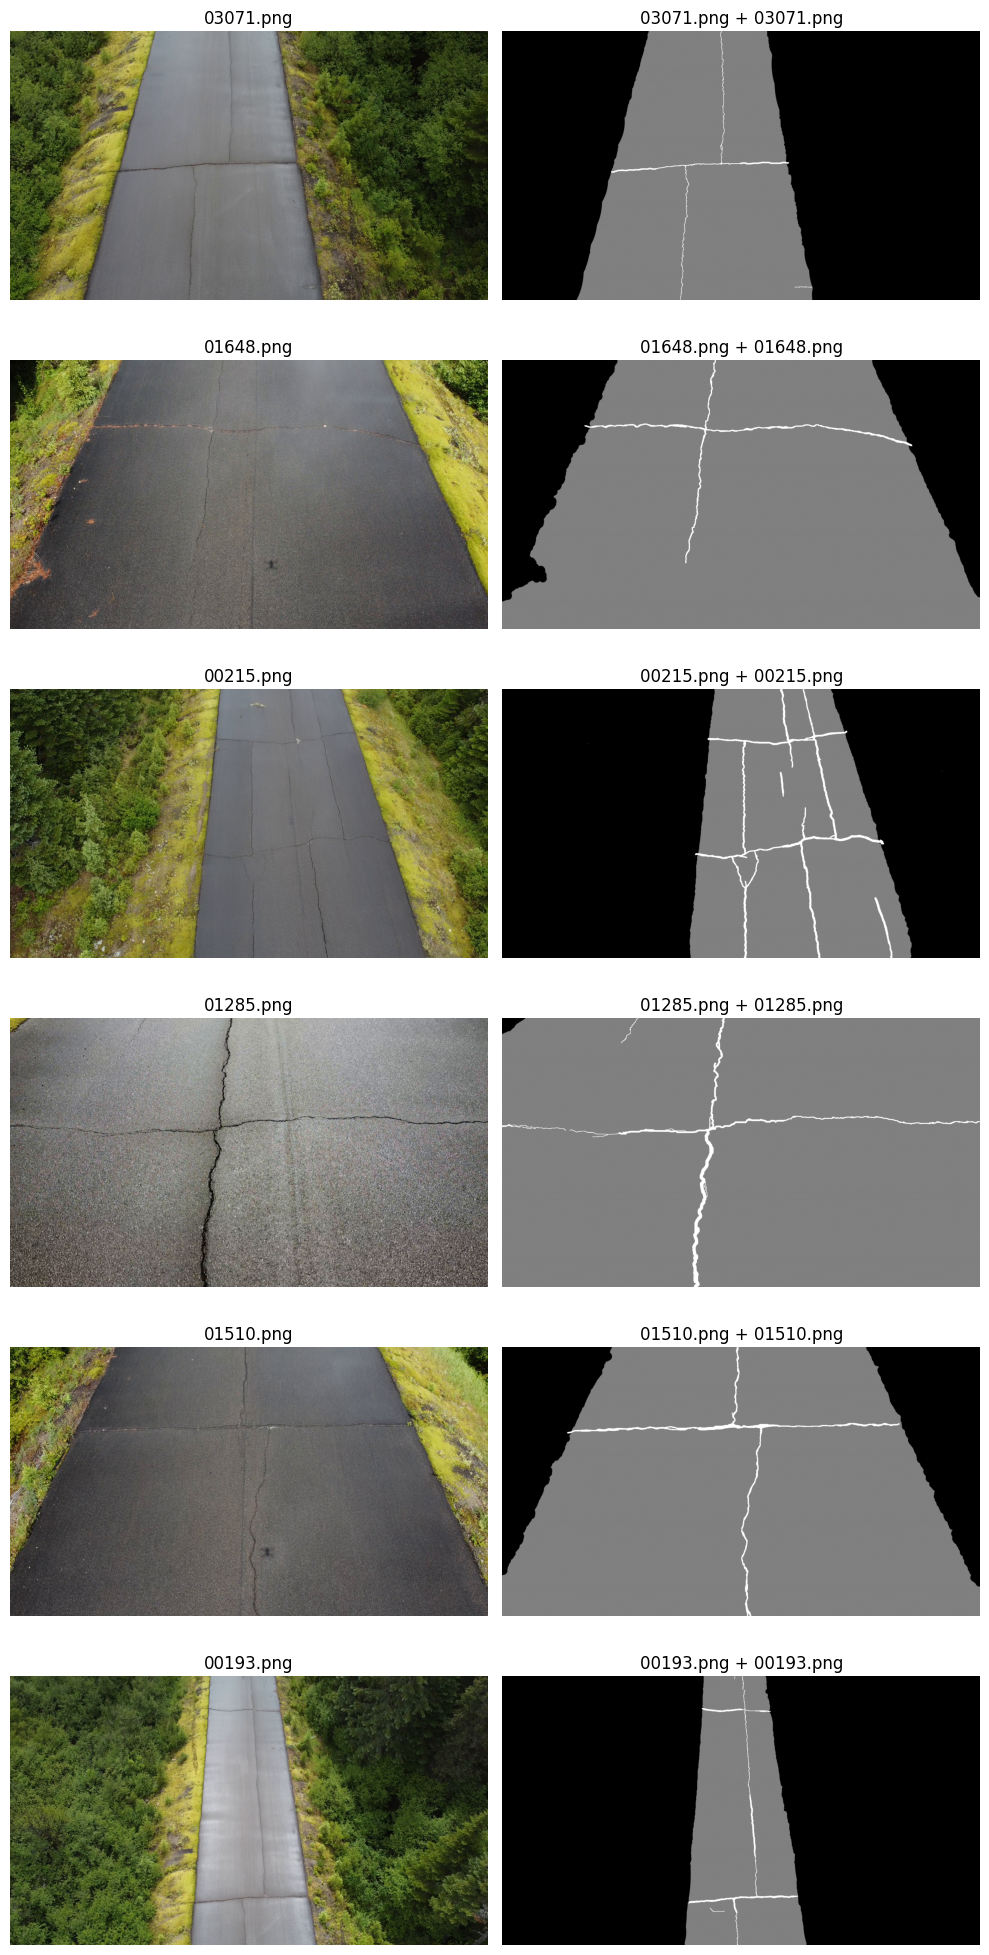

In [1]:
from pathlib import Path
from typing import List, Optional, Tuple

import torch
from torch import Tensor
from torch.utils.data import DataLoader
from torchvision.datasets import VisionDataset
from torchvision.io import read_image
import matplotlib.pyplot as plt


class CrackPavementTVDataset(VisionDataset):
    """
    Dataset minimalista usando torchvision.io.read_image.
    Cada muestra es un par (image, label) donde:
      - image: Tensor [3,H,W], float32 en [0,1]
      - label: Tensor [2,H,W], int64 (canal0=calle, canal1=grieta)
    """

    def __init__(
        self,
        root: Path,
        sessions: Optional[List[str]] = None,
        transforms=None,
    ) -> None:
        super().__init__(root=str(root), transforms=transforms)
        # recopilar tripletas (img, mask, target)
        self.samples: List[Tuple[Path, Path, Path]] = []
        paths_folders = sorted(p for p in root.iterdir() if p.name.startswith("SESSION"))
        for path_folder in paths_folders:
            path_folder_img = path_folder / "img"
            path_folder_mask = path_folder / "mask"
            path_folder_target = path_folder / "target"

            for path_img in sorted(path_folder_img.glob("*.png")):
                path_mask = path_folder_mask / path_img.name
                path_target = path_folder_target / path_img.name
                if not path_mask.exists() or not path_target.exists():
                    raise FileNotFoundError(f"{path_img.name} sin mask/target")
                self.samples.append((path_img, path_mask, path_target))

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int) -> Tuple[Tensor, Tensor]:
        img_path, msk_path, tgt_path = self.samples[idx]

        img: Tensor = read_image(str(img_path)).float().div_(255)  # [3,H,W]
        msk = read_image(str(msk_path))[0]  # [H,W]
        tgt = read_image(str(tgt_path))[0]  # [H,W]

        label = torch.stack(
            [(msk > 0).long(), (tgt > 0).long()], dim=0
        )  # [2,H,W]

        if self.transforms:
            img, label = self.transforms(img, label)

        return img, label

    def show_samples(
        self,
        num_samples: int = 4,
        figsize: Tuple[int, int] = (6, 4 * 4),
        cmap: str = "gray",
        dpi: int = 100,
        unified: bool = False,
    ) -> None:
        """
        Muestra ejemplos verticalmente.
        - Si unified=False: 3 columnas (img | mask calle | mask grieta).
        - Si unified=True: 2 columnas (img | máscara unificada 0/1/2).
        """
        from random import sample
        tripletas = sample(self.samples, k=min(num_samples, len(self.samples)))
        nrows = len(tripletas)
        ncols = 2 if unified else 3

        fig, axes = plt.subplots(nrows, ncols, figsize=figsize, dpi=dpi)
        axes = axes.reshape(nrows, ncols)

        for i, (img_p, msk_p, tgt_p) in enumerate(tripletas):
            # leer directamente para evitar preprocesos
            img_arr = plt.imread(str(img_p))
            msk_arr = plt.imread(str(msk_p))[..., 0]
            tgt_arr = plt.imread(str(tgt_p))[..., 0]

            # columna 0: imagen
            ax = axes[i, 0]
            ax.imshow(img_arr)
            ax.set_title(img_p.name)
            ax.axis("off")

            if unified:
                # construir máscara unificada
                uni = msk_arr.copy()
                uni[tgt_arr > 0] = 2  # target pisa mask
                ax2 = axes[i, 1]
                ax2.imshow(uni, cmap=cmap, vmin=0, vmax=2)
                ax2.set_title(f"{msk_p.name} + {tgt_p.name}")
                ax2.axis("off")
            else:
                # máscara calle
                ax1 = axes[i, 1]
                ax1.imshow(msk_arr, cmap=cmap)
                ax1.set_title(msk_p.name)
                ax1.axis("off")
                # máscara grieta
                ax2 = axes[i, 2]
                ax2.imshow(tgt_arr, cmap=cmap)
                ax2.set_title(tgt_p.name)
                ax2.axis("off")

        plt.tight_layout()
        plt.show()


dataset = CrackPavementTVDataset(Path("data/cracks_pavement"))
dataset.show_samples(num_samples=6, figsize=(10, 20), unified=True)

In [ ]:
for batch in dataset:
    #img, label = batch
    #print(img.shape)
    #print(label.shape)
    break

In [ ]:
len(batch)

In [ ]:
img, label = batch
print(img.shape)
print(label.shape)

In [ ]:
label.unique()